In [29]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [30]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [31]:
#create dataset loader class

class DatasetLoader(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        min_max = MinMaxScaler()

        x = self.data.values[:, :-1]

        self.y = torch.tensor(self.data.values[:, -1])
        self.y = self.y.type(torch.LongTensor)
        self.X = torch.tensor(min_max.fit_transform(x), dtype=torch.float32)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]





In [32]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.sequential = nn.Sequential(
      nn.Linear(13, 64),
      nn.ReLU(),
      nn.Linear(64, 64),
      nn.ReLU(),
      nn.Linear(64, 2),
    )

  def forward(self, x):
    return self.sequential(x)


In [65]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)

    model.train()

    for batch_idx, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()

        optimizer.zero_grad()
        
        if batch_idx % 20 == 0:
            loss, current = loss.item(),batch_idx * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    y_pred = None
    y_return = None
    
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            y_pred = pred
            y_return = y
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return y_pred, y_return

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Epoch 1
 ---------------------------
loss: 0.691698  [  100/  717]
Test Error: 
 Accuracy: 70.1%, Avg loss: 0.586311 

Epoch 2
 ---------------------------
loss: 0.570777  [  100/  717]
Test Error: 
 Accuracy: 80.8%, Avg loss: 0.413924 

Epoch 3
 ---------------------------
loss: 0.367396  [  100/  717]
Test Error: 
 Accuracy: 83.1%, Avg loss: 0.368165 

Epoch 4
 ---------------------------
loss: 0.309009  [  100/  717]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.358864 

Epoch 5
 ---------------------------
loss: 0.267486  [  100/  717]
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.383658 

Epoch 6
 ---------------------------
loss: 0.261515  [  100/  717]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.386950 

Epoch 7
 ---------------------------
loss: 0.261963  [  100/  717]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.353253 

Epoch 8
 ---------------------------
loss: 0.248799  [  100/  717]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.328824 

Epoch 9
 ---------------------------
loss: 0.225

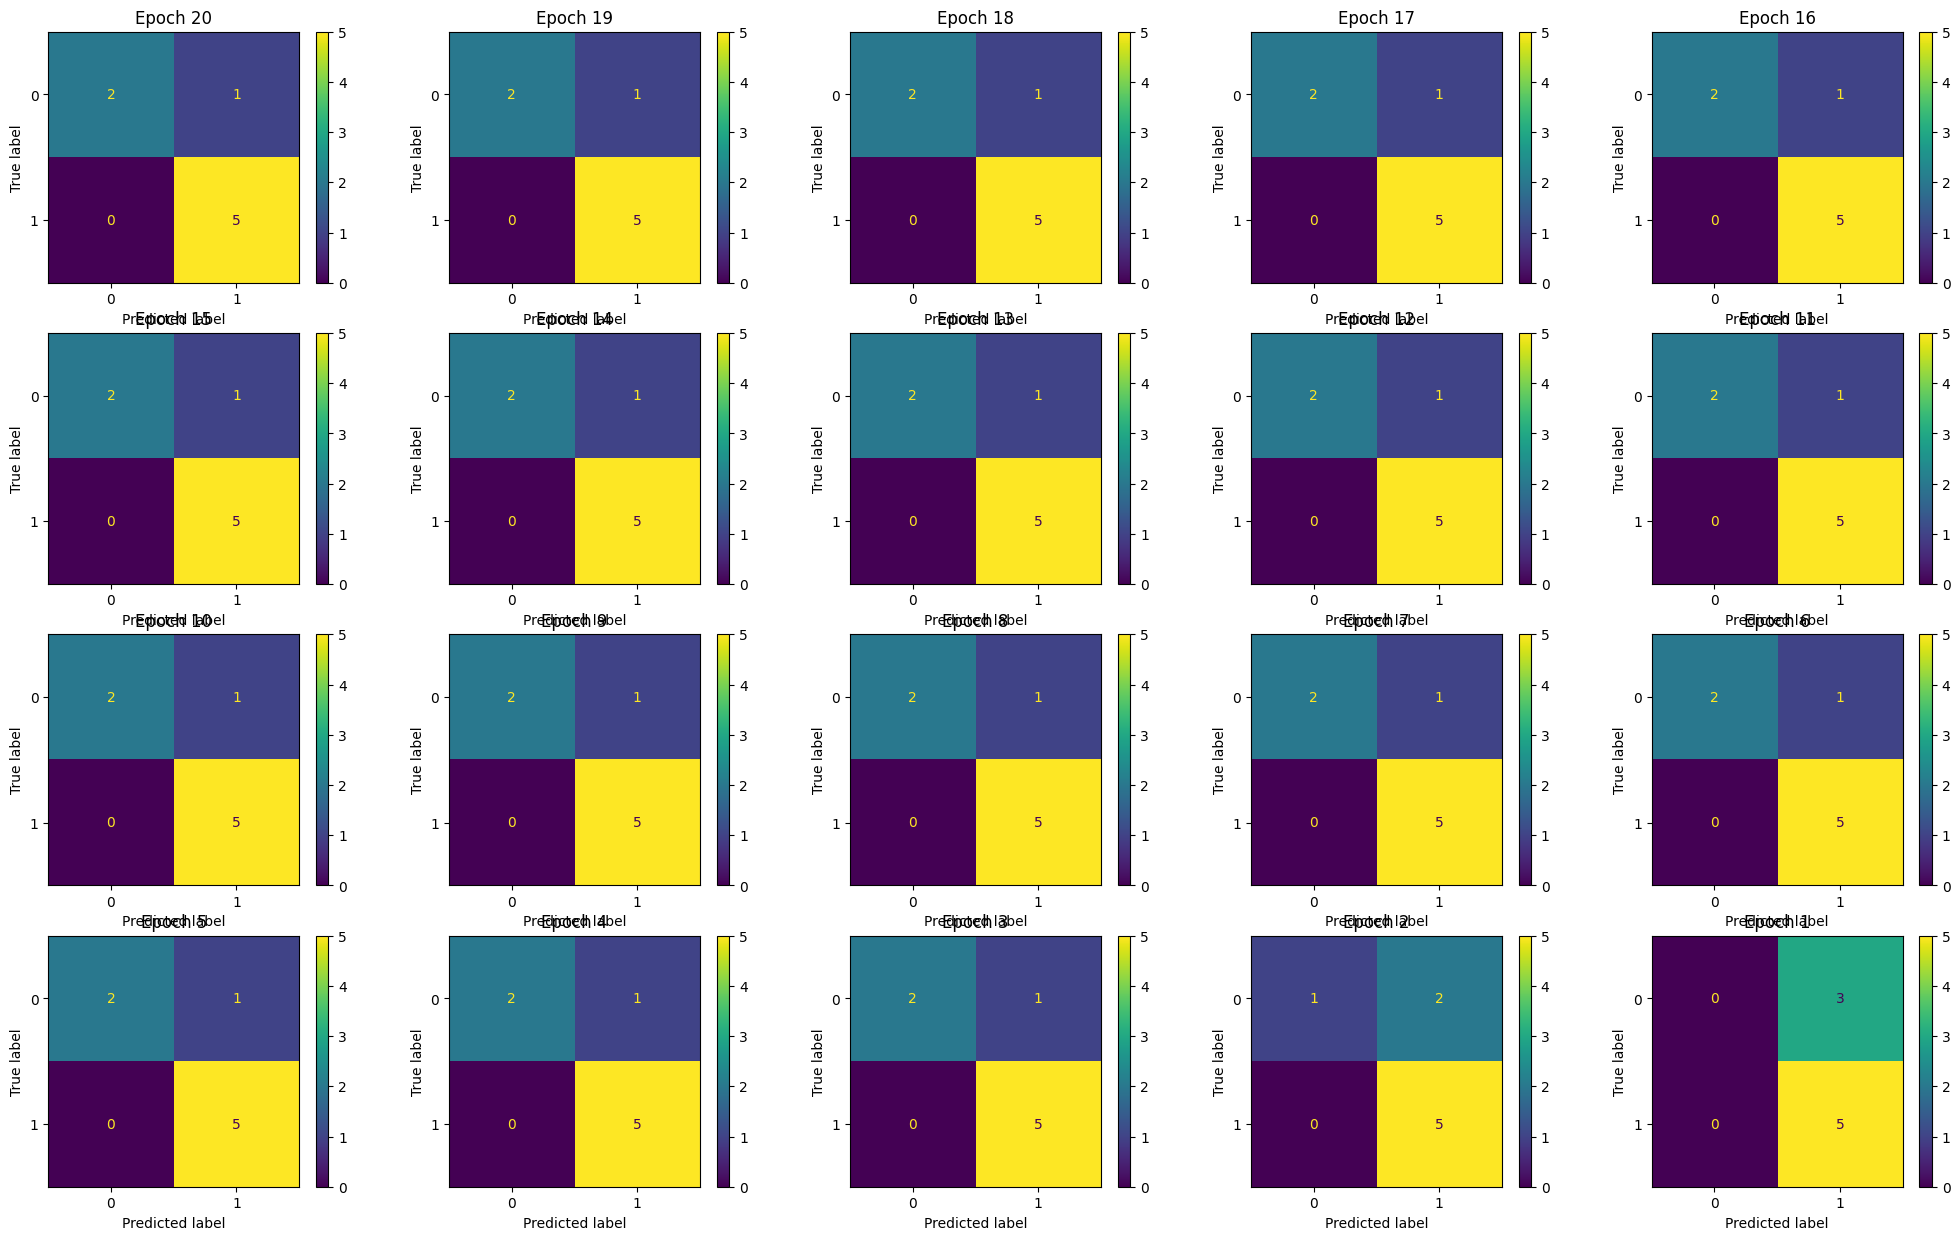

In [89]:
def get_row_number(i):
   if (i < 5):
    return 0
   
   if (i < 10):
    return 1
   
   if (i < 15):
    return 2
   
   if (i <= 20):
    return 3


def main():
  batch_size = 100
  learning_rate = 0.03
  epochs = 20

  dataset = DatasetLoader('./datasets/heart.csv')

  train_data, test_data = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.7), len(dataset) - int(len(dataset) * 0.7) ])

  train_loader = DataLoader(train_data, batch_size=batch_size)
  test_loader = DataLoader(test_data, batch_size=batch_size)
  
  model = NeuralNetwork()

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  y_reals, y_preds = [], []
  for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n ---------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, batch_size)
    y_pred, y_real = test_loop(test_loader, model, loss_fn)

    y_reals.append(y_real.detach())
    y_preds.append(y_pred.detach().numpy().argmax(1))

  _, axes = plt.subplots(4, 5, figsize=(25,15))
  
  for i in range(epochs):
    real_idx = len(y_reals) - i - 1
    print(real_idx)
    cm = confusion_matrix(y_reals[real_idx], y_preds[real_idx])
    disp = ConfusionMatrixDisplay(cm)
    
    disp.plot(ax=axes[get_row_number(i)][i%5])
    disp.ax_.set_title(f'Epoch {real_idx + 1}')
  plt.show()

main()




In [ ]:
# 1- age (0-99)
# 2- sex (1= male, 0 = female)
# 3- chest pain type (4 values) 0 - 3
# 4- resting blood pressure (90 - 200)
# 5- serum cholestoral in mg/dl 120 - 600
# 6- fasting blood sugar > 120 mg/dl 0 - 1
# 7- resting electrocardiographic results (values 0,1,2)
# 8- maximum heart rate achieved (60-202)
# 9- exercise induced angina 0 - 1
# 10- oldpeak = ST depression induced by exercise relative to rest (0 - 6.2)
# 11- the slope of the peak exercise ST segment (0-2)
# 12- number of major vessels (0-3) colored by flourosopy 0-3
# 13 -thal: 0 = normal; 1 = fixed defect; 2 = reversable defect 0-2